In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_from_disk
import numpy as np
from pathlib import Path
import matplotlib

class SilenceProbe(nn.Module):
    def __init__(self, hidden_dim=1024):
        super().__init__()
        self.probe = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.probe(x))

def train_probe(dataset_path, batch_size=1024, lr=1e-3, epochs=10):
    # Load datasets
    train_ds = load_from_disk(str(Path(dataset_path) / 'train'))
    val_ds = load_from_disk(str(Path(dataset_path) / 'val'))
    
    # Stack all frames into big tensors
    def prepare_data(ds):
        hidden_states = np.vstack([h for sample in ds['hidden_states'] for h in sample])
        is_silence = np.hstack([s for sample in ds['is_silence'] for s in sample])
        return torch.FloatTensor(hidden_states), torch.FloatTensor(is_silence)
    
    X_train, y_train = prepare_data(train_ds)
    X_val, y_val = prepare_data(val_ds)
    
    train_loader = DataLoader(
        TensorDataset(X_train, y_train), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    # Initialize model and training
    model = SilenceProbe()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    print(f"Training on {len(X_train)} frames, validating on {len(X_val)} frames")
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X).squeeze()
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val).squeeze()
            val_loss = criterion(val_pred, y_val)
            
            # Calculate accuracy with threshold 0.5
            val_acc = ((val_pred > 0.5) == y_val).float().mean()
            
            # Calculate F1 score
            pred_bool = val_pred > 0.5
            true_pos = (pred_bool & y_val.bool()).sum()
            precision = true_pos / (pred_bool.sum() + 1e-8)
            recall = true_pos / (y_val.sum() + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train loss: {train_loss/len(train_loader):.4f}")
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}, Val F1: {f1:.4f}")
        print()
    
    return model

# Train it!
model = train_probe('./silence_dataset')

Training on 57054 frames, validating on 6347 frames
Epoch 1/10
Train loss: 0.9433
Val loss: 0.3956, Val acc: 0.9764, Val F1: 0.9403

Epoch 2/10
Train loss: 0.4233
Val loss: 0.2981, Val acc: 0.9772, Val F1: 0.9423

Epoch 3/10
Train loss: 0.2817
Val loss: 0.4871, Val acc: 0.9707, Val F1: 0.9289

Epoch 4/10
Train loss: 0.2046
Val loss: 0.1818, Val acc: 0.9765, Val F1: 0.9402

Epoch 5/10
Train loss: 0.1494
Val loss: 0.1721, Val acc: 0.9770, Val F1: 0.9423

Epoch 6/10
Train loss: 0.1276
Val loss: 0.1327, Val acc: 0.9768, Val F1: 0.9410

Epoch 7/10
Train loss: 0.1100
Val loss: 0.1230, Val acc: 0.9765, Val F1: 0.9392

Epoch 8/10
Train loss: 0.1058
Val loss: 0.1724, Val acc: 0.9751, Val F1: 0.9381

Epoch 9/10
Train loss: 0.1007
Val loss: 0.2203, Val acc: 0.9672, Val F1: 0.9215

Epoch 10/10
Train loss: 0.0927
Val loss: 0.1143, Val acc: 0.9772, Val F1: 0.9425



In [14]:
import copy
import matplotlib.pyplot as plt

def prepare_silence_datasets(dataset_path, device="cuda"):
    """Prepare datasets for silence probe training."""
    train_ds = load_from_disk(str(Path(dataset_path) / 'train'))
    val_ds = load_from_disk(str(Path(dataset_path) / 'val'))
    
    def process_dataset(ds):
        hidden_states = []
        labels = []
        edge_silence_mask = []
        
        for sample in ds:
            states = sample['hidden_states']
            silence_mask = sample['is_silence']
            n_frames = len(states)
            
            # Find silence runs
            silence_runs = []
            in_run = False
            run_start = 0
            
            for i in range(n_frames):
                if silence_mask[i] and not in_run:
                    in_run = True
                    run_start = i
                elif not silence_mask[i] and in_run:
                    silence_runs.append((run_start, i))
                    in_run = False
            
            if in_run:
                silence_runs.append((run_start, n_frames))
                
            # Mark edge runs
            edge_runs = set()
            for start, end in silence_runs:
                if start == 0 or end == n_frames:
                    edge_runs.update(range(start, end))
            
            # Process frames
            for i in range(n_frames):
                hidden_states.append(states[i])
                is_middle_silence = (silence_mask[i] and 
                                   i not in edge_runs and
                                   0.1 < i/n_frames < 0.9)
                labels.append(float(is_middle_silence))
                edge_silence_mask.append(i in edge_runs)
                
        hidden_states = np.stack(hidden_states)
        edge_silence_mask = np.array(edge_silence_mask)
        
        return (torch.FloatTensor(hidden_states).to(device),
                torch.FloatTensor(labels).to(device),
                torch.BoolTensor(edge_silence_mask).to(device))
    
    print("Preparing datasets...")
    train_data = process_dataset(train_ds)
    val_data = process_dataset(val_ds)
    
    # Print statistics
    for name, (X, y, edge) in [("Training", train_data), ("Validation", val_data)]:
        pos_rate = (y == 1).float().mean()
        edge_rate = edge.float().mean()
        print(f"\n{name} set ({len(X)} frames):")
        print(f"- {pos_rate*100:.1f}% middle silence")
        print(f"- {edge_rate*100:.1f}% edge silence")
        print(f"- {(1-pos_rate-edge_rate)*100:.1f}% non-silence")
    
    return train_data, val_data

def plot_prediction_dist(val_pred_prob, y_val, edge_val, epoch, epochs):
    """Plot prediction distribution histogram."""
    plt.figure(figsize=(12, 4))
    plt.hist(val_pred_prob[(~edge_val) & (y_val == 0)].cpu().numpy(), 
            bins=50, alpha=0.5, label='Non-silence frames')
    plt.hist(val_pred_prob[edge_val].cpu().numpy(), 
            bins=50, alpha=0.5, label='Edge silence frames')
    plt.hist(val_pred_prob[y_val == 1].cpu().numpy(), 
            bins=50, alpha=0.5, label='Middle silence frames')
    plt.title(f'Prediction Distribution by Frame Type (Epoch {epoch}/{epochs})')
    plt.legend()
    plt.show()

def train_pause_type_probe(train_data, val_data, batch_size=256, lr=1e-3, epochs=20):
    """Train the silence probe model."""
    X_train, y_train, _ = train_data
    X_val, y_val, edge_val = val_data
    
    train_loader = DataLoader(
        TensorDataset(X_train, y_train), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    model = PauseTypeProbe(hidden_dim=X_train.shape[1]).to(X_train.device)
    pos_weight = torch.tensor([(1 - y_train.mean()) / y_train.mean()]).to(X_train.device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X).squeeze()
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_preds.extend((torch.sigmoid(pred) > 0.5).cpu().numpy())
            train_labels.extend(batch_y.cpu().numpy())
        
        train_loss /= len(train_loader)
        train_acc = (np.array(train_preds) == np.array(train_labels)).mean()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val).squeeze()
            val_pred_prob = torch.sigmoid(val_pred)
            val_pred_bool = val_pred_prob > 0.5
            
            val_loss = criterion(val_pred, y_val)
            val_acc = (val_pred_bool == y_val).float().mean()
            
            # Core metrics
            true_pos = (val_pred_bool & (y_val == 1)).sum().item()
            false_pos = (val_pred_bool & (y_val == 0)).sum().item()
            false_neg = (~val_pred_bool & (y_val == 1)).sum().item()
            
            precision = true_pos / (true_pos + false_pos + 1e-8)
            recall = true_pos / (true_pos + false_neg + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            edge_trigger_rate = (val_pred_bool & edge_val).float().mean()
            
            if f1 > best_f1:
                best_f1 = f1
                best_model = copy.deepcopy(model)
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print(f"Edge silence trigger rate: {edge_trigger_rate:.4f}")
        
        if (epoch + 1) % 5 == 0:
            plot_prediction_dist(val_pred_prob, y_val, edge_val, epoch+1, epochs)
    
    print(f"\nBest validation F1: {best_f1:.4f}")
    return best_model

class PauseTypeProbe(nn.Module):
    def __init__(self, hidden_dim=1024):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        return self.linear(x)

In [15]:
# First load/prep datasets
train_data, val_data = prepare_silence_datasets('./silence_dataset')

Preparing datasets...

Training set (57054 frames):
- 13.5% middle silence
- 2.4% edge silence
- 84.0% non-silence

Validation set (6347 frames):
- 15.1% middle silence
- 2.0% edge silence
- 82.9% non-silence



Epoch 1/20
Train loss: 1.4727, Train acc: 0.9180
Val loss: 0.8129, Val acc: 0.9360
Precision: 0.7204, Recall: 0.9438, F1: 0.8171
Edge silence trigger rate: 0.0079

Epoch 2/20
Train loss: 0.6400, Train acc: 0.9432
Val loss: 0.8558, Val acc: 0.9411
Precision: 0.7642, Recall: 0.8835, F1: 0.8195
Edge silence trigger rate: 0.0068

Epoch 3/20
Train loss: 0.5434, Train acc: 0.9457
Val loss: 0.9520, Val acc: 0.9256
Precision: 0.6770, Recall: 0.9729, F1: 0.7985
Edge silence trigger rate: 0.0159

Epoch 4/20
Train loss: 0.5845, Train acc: 0.9450
Val loss: 0.7434, Val acc: 0.9474
Precision: 0.7719, Recall: 0.9261, F1: 0.8420
Edge silence trigger rate: 0.0057

Epoch 5/20
Train loss: 0.5302, Train acc: 0.9485
Val loss: 0.7516, Val acc: 0.9376
Precision: 0.7195, Recall: 0.9636, F1: 0.8238
Edge silence trigger rate: 0.0085


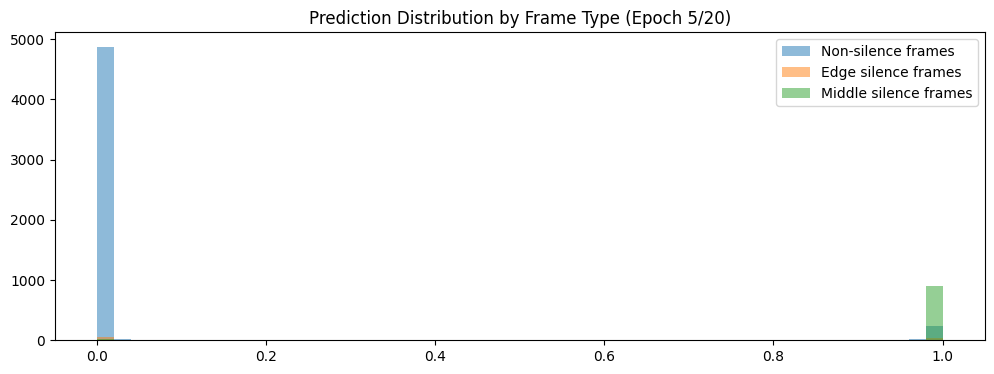


Epoch 6/20
Train loss: 0.5014, Train acc: 0.9503
Val loss: 0.7706, Val acc: 0.9431
Precision: 0.7427, Recall: 0.9553, F1: 0.8357
Edge silence trigger rate: 0.0093

Epoch 7/20
Train loss: 0.5123, Train acc: 0.9485
Val loss: 0.8681, Val acc: 0.9493
Precision: 0.7825, Recall: 0.9209, F1: 0.8461
Edge silence trigger rate: 0.0052

Epoch 8/20
Train loss: 0.5649, Train acc: 0.9488
Val loss: 0.8940, Val acc: 0.9452
Precision: 0.7506, Recall: 0.9553, F1: 0.8407
Edge silence trigger rate: 0.0071

Epoch 9/20
Train loss: 0.4724, Train acc: 0.9530
Val loss: 0.7834, Val acc: 0.9343
Precision: 0.7076, Recall: 0.9646, F1: 0.8164
Edge silence trigger rate: 0.0106

Epoch 10/20
Train loss: 0.4926, Train acc: 0.9519
Val loss: 0.9391, Val acc: 0.9267
Precision: 0.6813, Recall: 0.9698, F1: 0.8003
Edge silence trigger rate: 0.0139


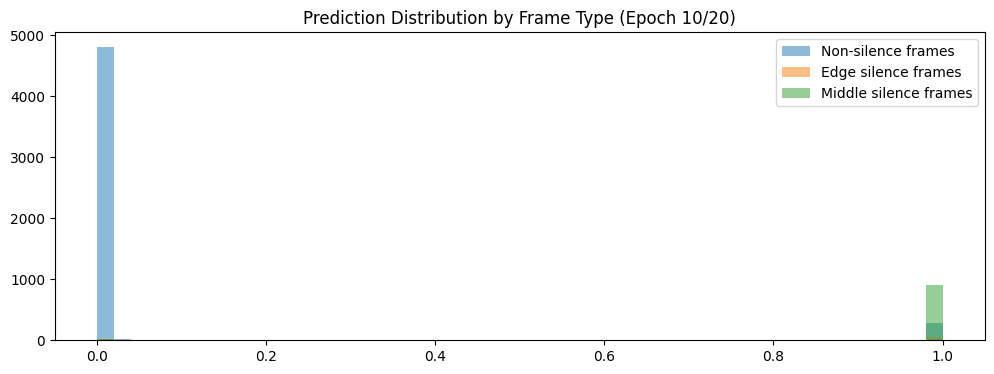


Epoch 11/20
Train loss: 0.5032, Train acc: 0.9510
Val loss: 0.7744, Val acc: 0.9318
Precision: 0.7003, Recall: 0.9605, F1: 0.8100
Edge silence trigger rate: 0.0098

Epoch 12/20
Train loss: 0.5003, Train acc: 0.9509
Val loss: 0.9842, Val acc: 0.9475
Precision: 0.7849, Recall: 0.9001, F1: 0.8386
Edge silence trigger rate: 0.0054

Epoch 13/20
Train loss: 0.5120, Train acc: 0.9513
Val loss: 0.9845, Val acc: 0.9357
Precision: 0.7322, Recall: 0.9074, F1: 0.8104
Edge silence trigger rate: 0.0041

Epoch 14/20
Train loss: 0.5351, Train acc: 0.9498
Val loss: 0.7530, Val acc: 0.9382
Precision: 0.7228, Recall: 0.9605, F1: 0.8248
Edge silence trigger rate: 0.0068

Epoch 15/20
Train loss: 0.4859, Train acc: 0.9541
Val loss: 0.9364, Val acc: 0.9272
Precision: 0.6812, Recall: 0.9761, F1: 0.8024
Edge silence trigger rate: 0.0110


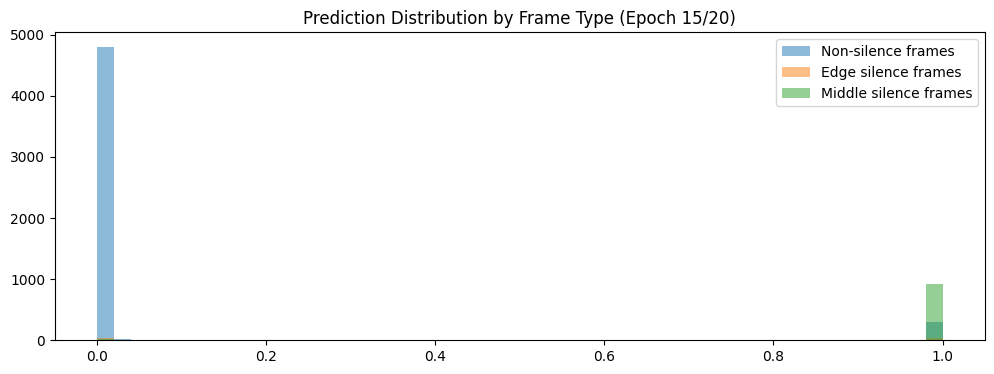


Epoch 16/20
Train loss: 0.4895, Train acc: 0.9528
Val loss: 0.9338, Val acc: 0.9467
Precision: 0.7882, Recall: 0.8866, F1: 0.8345
Edge silence trigger rate: 0.0044

Epoch 17/20
Train loss: 0.5069, Train acc: 0.9519
Val loss: 0.8478, Val acc: 0.9346
Precision: 0.7087, Recall: 0.9646, F1: 0.8171
Edge silence trigger rate: 0.0101

Epoch 18/20
Train loss: 0.4977, Train acc: 0.9527
Val loss: 1.0980, Val acc: 0.9269
Precision: 0.6799, Recall: 0.9771, F1: 0.8019
Edge silence trigger rate: 0.0143

Epoch 19/20
Train loss: 0.5591, Train acc: 0.9508
Val loss: 0.9870, Val acc: 0.9425
Precision: 0.7628, Recall: 0.9001, F1: 0.8258
Edge silence trigger rate: 0.0057

Epoch 20/20
Train loss: 0.5149, Train acc: 0.9532
Val loss: 0.8137, Val acc: 0.9415
Precision: 0.7454, Recall: 0.9324, F1: 0.8285
Edge silence trigger rate: 0.0043


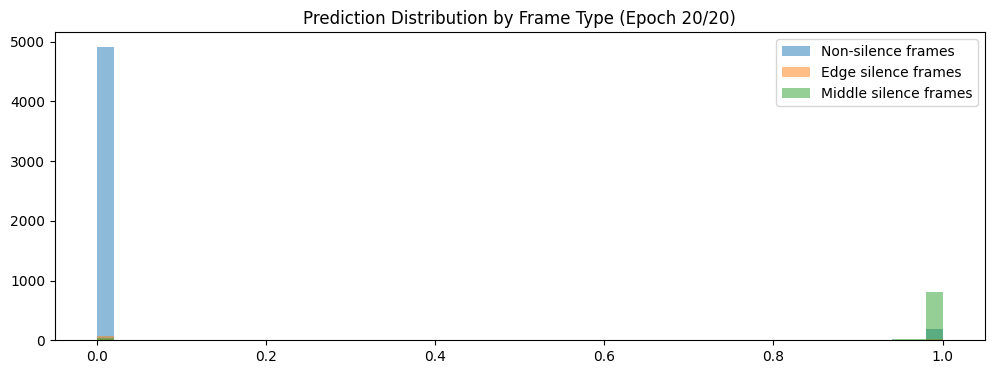


Best validation F1: 0.8461


In [33]:
# Train model (or use your existing one)
model = train_pause_type_probe(train_data, val_data, lr=1e-3, epochs=20)

In [37]:
from safetensors import safe_open
from safetensors.torch import save_file
from datetime import datetime

# Save best model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"silence_probe_{timestamp}.safetensors"
state_dict = model.state_dict()
save_file(state_dict, save_path)
print(f"\nSaved model to: {save_path}")


Saved model to: silence_probe_20241117_110157.safetensors


In [18]:
import pandas as pd

def analyze_thresholds(model, X_val, y_val, edge_val, n_thresholds=100):
    """Analyze different probability thresholds for the silence probe."""
    model.eval()
    with torch.no_grad():
        # Get raw predictions
        val_pred = torch.sigmoid(model(X_val)).squeeze().cpu().numpy()
        y_val = y_val.cpu().numpy()
        edge_val = edge_val.cpu().numpy()
        
        # Mask out edge frames
        non_edge_mask = ~edge_val
        clean_pred = val_pred[non_edge_mask]
        clean_labels = y_val[non_edge_mask]
        
        # Calculate metrics across thresholds
        thresholds = np.linspace(0, 1, n_thresholds)
        results = []
        
        for threshold in thresholds:
            pred_bool = val_pred >= threshold
            clean_pred_bool = clean_pred >= threshold
            
            # Calculate edge trigger rate
            edge_trigger_rate = (pred_bool & edge_val).mean()
            
            # Calculate clean metrics (excluding edge frames)
            true_pos = (clean_pred_bool & (clean_labels == 1)).sum()
            false_pos = (clean_pred_bool & (clean_labels == 0)).sum()
            false_neg = (~clean_pred_bool & (clean_labels == 1)).sum()
            
            precision = true_pos / (true_pos + false_pos + 1e-8)
            recall = true_pos / (true_pos + false_neg + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'edge_trigger_rate': edge_trigger_rate
            })
            
        results = pd.DataFrame(results)
        
        # Plot results
        plt.figure(figsize=(15, 5))
        
        # Plot 1: PR curve with F1
        plt.subplot(131)
        plt.plot(results['recall'], results['precision'], 'b-', label='PR curve')
        plt.scatter(results['recall'], results['precision'], 
                   c=results['f1'], cmap='viridis', 
                   label='F1 score')
        plt.colorbar(label='F1 score')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        
        # Plot 2: Metrics vs threshold
        plt.subplot(132)
        plt.plot(results['threshold'], results['precision'], 'r-', label='Precision')
        plt.plot(results['threshold'], results['recall'], 'b-', label='Recall')
        plt.plot(results['threshold'], results['f1'], 'g-', label='F1')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.legend()
        plt.title('Metrics vs Threshold')
        
        # Plot 3: Edge trigger rate vs threshold
        plt.subplot(133)
        plt.plot(results['threshold'], results['edge_trigger_rate'], 'k-')
        plt.xlabel('Threshold')
        plt.ylabel('Edge Trigger Rate')
        plt.title('Edge Trigger Rate vs Threshold')
        
        plt.tight_layout()
        plt.show()
        
        # Find optimal thresholds
        best_f1_idx = results['f1'].argmax()
        best_f1_threshold = results.loc[best_f1_idx, 'threshold']
        
        high_prec_mask = results['precision'] >= 0.9
        if high_prec_mask.any():
            high_prec_results = results[high_prec_mask]
            best_high_prec_idx = high_prec_results['recall'].argmax()
            high_prec_threshold = high_prec_results.iloc[best_high_prec_idx]['threshold']
        else:
            high_prec_threshold = None
            
        print("\nOptimal Thresholds:")
        print(f"Best F1 (threshold = {best_f1_threshold:.3f}):")
        print_metrics(results.loc[best_f1_idx])
        
        if high_prec_threshold is not None:
            print(f"\nHigh Precision (threshold = {high_prec_threshold:.3f}):")
            high_prec_row = results[results['threshold'] == high_prec_threshold].iloc[0]
            print_metrics(high_prec_row)
            
        return results

def print_metrics(row):
    """Helper to print metrics for a threshold."""
    print(f"Precision: {row['precision']:.3f}")
    print(f"Recall: {row['recall']:.3f}")
    print(f"F1: {row['f1']:.3f}")
    print(f"Edge Trigger Rate: {row['edge_trigger_rate']:.3f}")

# Usage:
# results = analyze_thresholds(model, X_val, y_val, edge_val)

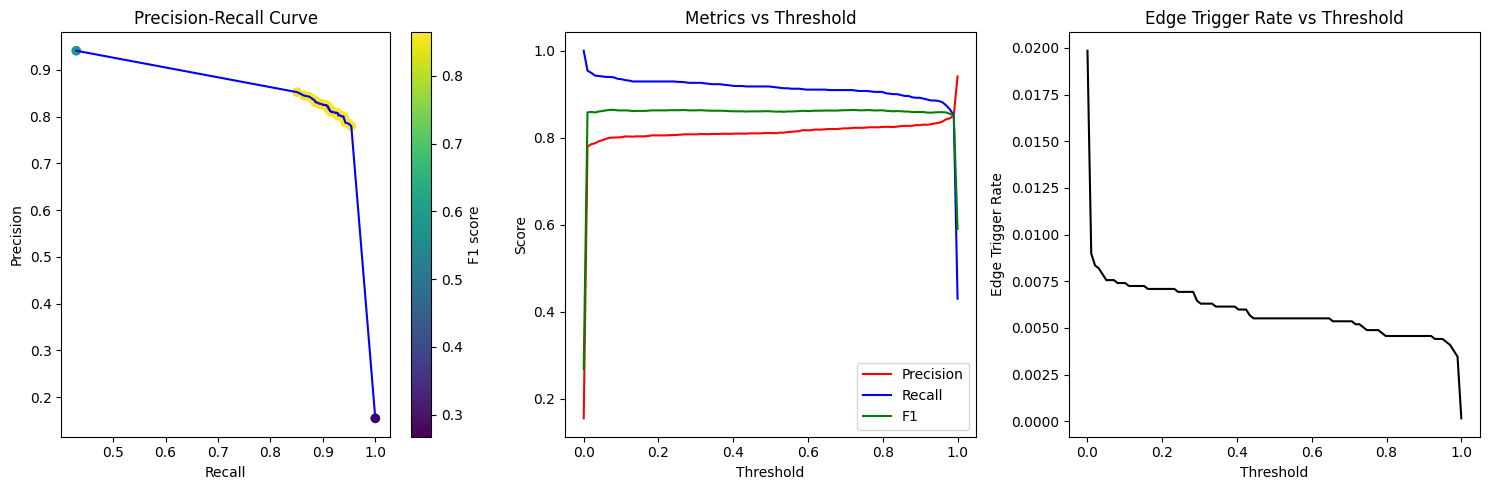


Optimal Thresholds:
Best F1 (threshold = 0.071):
Precision: 0.800
Recall: 0.940
F1: 0.864
Edge Trigger Rate: 0.008

High Precision (threshold = 1.000):
Precision: 0.941
Recall: 0.430
F1: 0.590
Edge Trigger Rate: 0.000


In [19]:
X_val, y_val, edge_val = val_data
results = analyze_thresholds(model, X_val, y_val, edge_val)

In [20]:
def analyze_errors(model, val_data, threshold=0.4):
    """Analyze and visualize prediction errors."""
    X_val, y_val, edge_val = val_data
    model.eval()
    
    with torch.no_grad():
        # Get predictions
        pred_probs = torch.sigmoid(model(X_val)).squeeze().cpu().numpy()
        y_true = y_val.cpu().numpy()
        edge_mask = edge_val.cpu().numpy()
        
        # Find error cases
        pred_bool = pred_probs >= threshold
        errors = pred_bool != y_true
        
        # Separate false positives and negatives
        false_pos = errors & ~y_true & ~edge_mask  # Predicted silence when shouldn't (excluding edges)
        false_neg = errors & y_true  # Missed real silence
        edge_triggers = pred_bool & edge_mask  # Edge frames we incorrectly triggered on
        
        def plot_error_sequence(sample_idx, window=50):
            """Plot a window around an error with context."""
            start = max(0, sample_idx - window//2)
            end = min(len(pred_probs), sample_idx + window//2)
            
            time = np.arange(start, end) / 21.535  # Convert to seconds
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), height_ratios=[1, 2])
            fig.suptitle(f'Error Analysis Around Frame {sample_idx}')
            
            # Ground truth
            ax1.fill_between(time, 0, 1, 
                           where=y_true[start:end]==1,
                           color='red', alpha=0.3, label='Ground Truth Silence')
            ax1.fill_between(time, 0, 1,
                           where=edge_mask[start:end],
                           color='gray', alpha=0.3, label='Edge Region')
            ax1.set_title('Ground Truth')
            ax1.legend()
            
            # Predictions
            ax2.plot(time, pred_probs[start:end], 'b-', label='Silence Probability')
            ax2.axhline(y=threshold, color='g', linestyle='--', label='Threshold')
            
            # Highlight errors
            ax2.fill_between(time, 0, 1,
                           where=false_pos[start:end],
                           color='red', alpha=0.3, label='False Positive')
            ax2.fill_between(time, 0, 1,
                           where=false_neg[start:end],
                           color='blue', alpha=0.3, label='False Negative')
            ax2.fill_between(time, 0, 1,
                           where=edge_triggers[start:end],
                           color='yellow', alpha=0.3, label='Edge Trigger')
            
            ax2.set_xlabel('Time (seconds)')
            ax2.set_ylabel('Probability')
            ax2.legend()
            plt.tight_layout()
            plt.show()
        
        # Analysis of where errors occur
        rel_positions = []  # Relative position in sequence
        for i in range(len(pred_probs)):
            if errors[i]:
                seq_len = len(pred_probs)  # Should really be per-sequence length
                rel_pos = i / seq_len
                rel_positions.append({
                    'position': rel_pos,
                    'type': 'false_pos' if false_pos[i] else 'false_neg' if false_neg[i] else 'edge',
                    'prob': pred_probs[i],
                    'frame': i
                })
        
        error_df = pd.DataFrame(rel_positions)
        
        # Plot error distribution
        plt.figure(figsize=(12, 6))
        plt.hist([error_df[error_df['type'] == t]['position'] for t in ['false_pos', 'false_neg', 'edge']], 
                label=['False Positives', 'False Negatives', 'Edge Triggers'],
                bins=20, alpha=0.5)
        plt.xlabel('Relative Position in Sequence')
        plt.ylabel('Error Count')
        plt.title('Distribution of Errors by Position')
        plt.legend()
        plt.show()
        
        # Print summary stats
        print("\nError Analysis Summary:")
        print(f"False Positives: {false_pos.sum()}")
        print(f"False Negatives: {false_neg.sum()}")
        print(f"Edge Triggers: {edge_triggers.sum()}")
        
        # Return some error examples for detailed inspection
        fp_examples = np.where(false_pos)[0]
        fn_examples = np.where(false_neg)[0]
        edge_examples = np.where(edge_triggers)[0]
        
        return {
            'false_pos_frames': fp_examples,
            'false_neg_frames': fn_examples,
            'edge_frames': edge_examples,
            'plot_error': plot_error_sequence,
            'error_df': error_df
        }

# Usage:
# error_results = analyze_errors(model, val_data, threshold=0.4)
# 
# # To visualize specific errors:
# error_results['plot_error'](error_results['false_pos_frames'][0])  # First false positive
# error_results['plot_error'](error_results['false_neg_frames'][0])  # First false negative
# 
# # Look at error patterns near buffer zone:
# near_edge = error_results['error_df'][
#     (error_results['error_df']['position'] > 0.08) & 
#     (error_results['error_df']['position'] < 0.12)
# ]

In [21]:
error_results = analyze_errors(model, val_data, threshold=0.4)  # Using the validation data you already loaded

# Check first few examples of each error type
for i in range(min(3, len(error_results['false_pos_frames']))):
    error_results['plot_error'](error_results['false_pos_frames'][i])

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [22]:
def analyze_errors(model, val_data, threshold=0.4):
    """Analyze prediction errors."""
    X_val, y_val, edge_val = val_data
    model.eval()
    
    with torch.no_grad():
        pred_probs = torch.sigmoid(model(X_val)).squeeze().cpu().numpy()
        y_true = y_val.cpu().numpy()
        edge_mask = edge_val.cpu().numpy()
        
        pred_bool = pred_probs >= threshold
        errors = pred_bool != y_true
        
        # All to numpy
        false_pos = errors & (y_true == 0) & (edge_mask == 0)
        false_neg = errors & (y_true == 1)
        edge_triggers = pred_bool & edge_mask
        
        print("\nError Analysis Summary:")
        print(f"False Positives: {false_pos.sum()}")
        print(f"False Negatives: {false_neg.sum()}")
        print(f"Edge Triggers: {edge_triggers.sum()}")
        
        fp_frames = np.where(false_pos)[0]
        fn_frames = np.where(false_neg)[0]
        edge_frames = np.where(edge_triggers)[0]

        return fp_frames, fn_frames, edge_frames

# Just run:
fp_frames, fn_frames, edge_frames = analyze_errors(model, val_data, threshold=0.4)
print("\nFirst few error frames:")
print(f"False positive frames: {fp_frames[:5]}")
print(f"False negative frames: {fn_frames[:5]}")
print(f"Edge trigger frames: {edge_frames[:5]}")


Error Analysis Summary:
False Positives: 209
False Negatives: 78
Edge Triggers: 39

First few error frames:
False positive frames: [12 13 14 15 16]
False negative frames: [183 210 364 427 434]
Edge trigger frames: [   1    2    3 1426 1427]


False Positive Example:


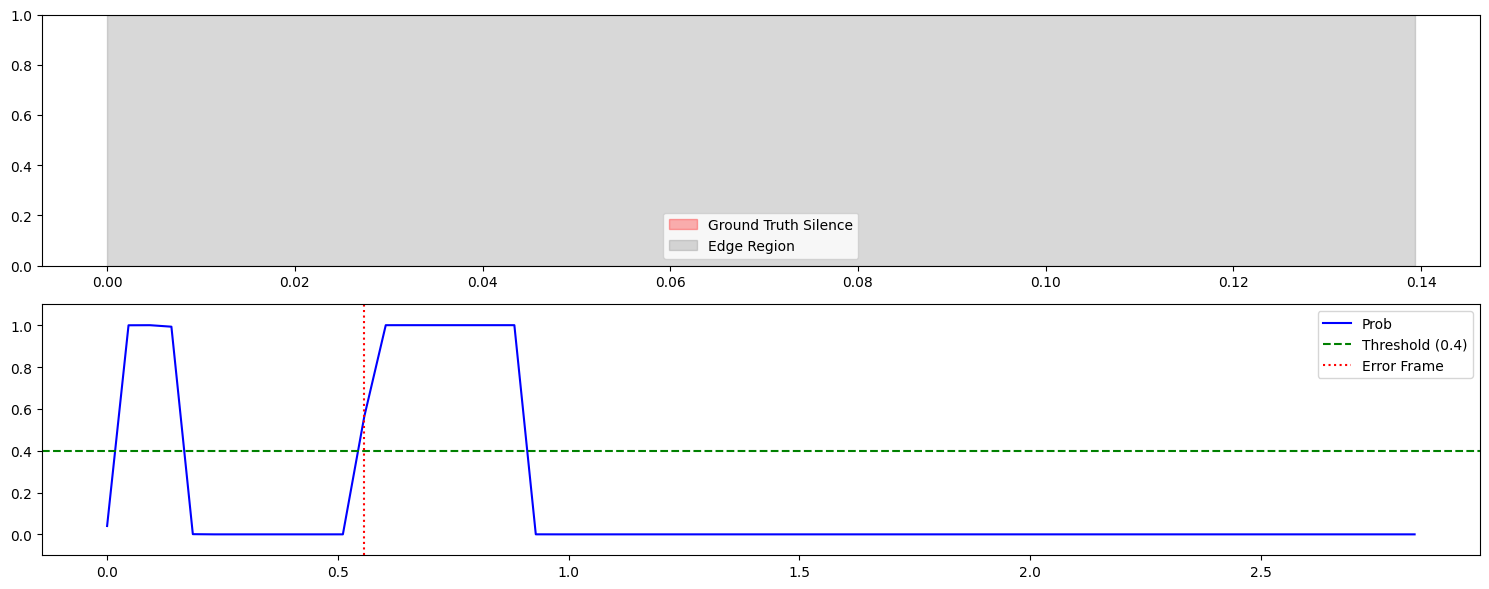


False Negative Example:


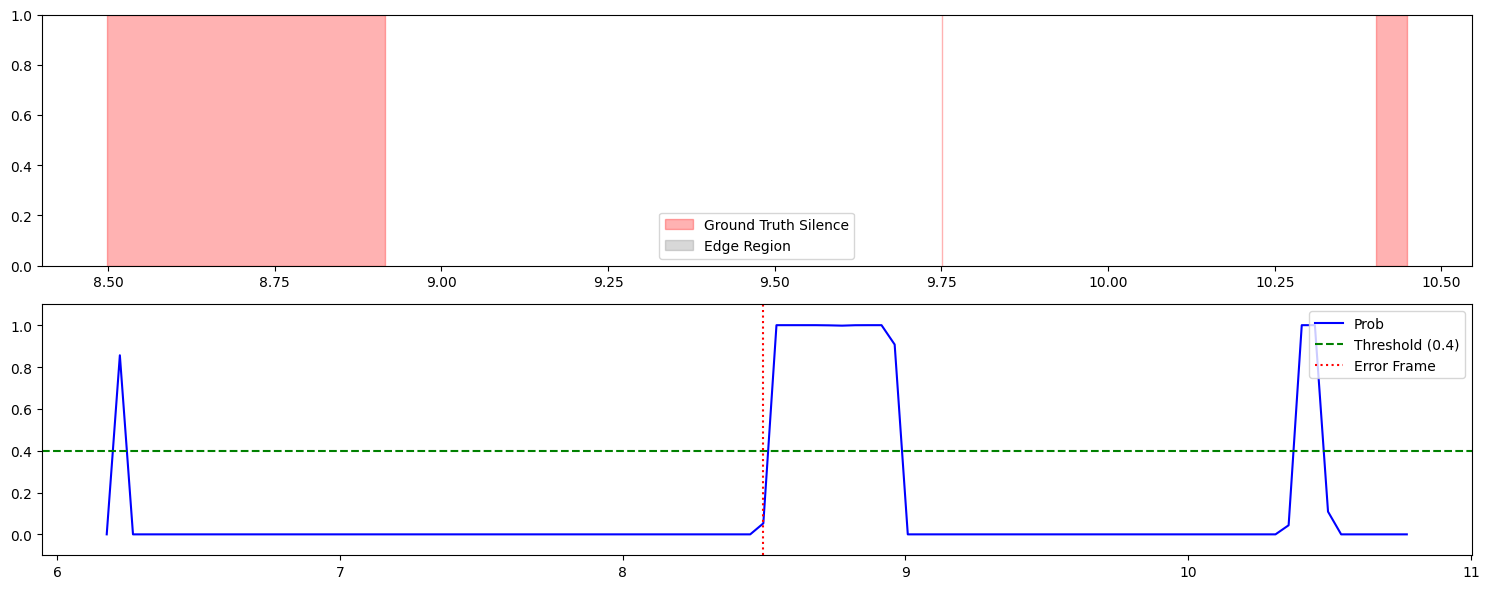


Edge Trigger Example:


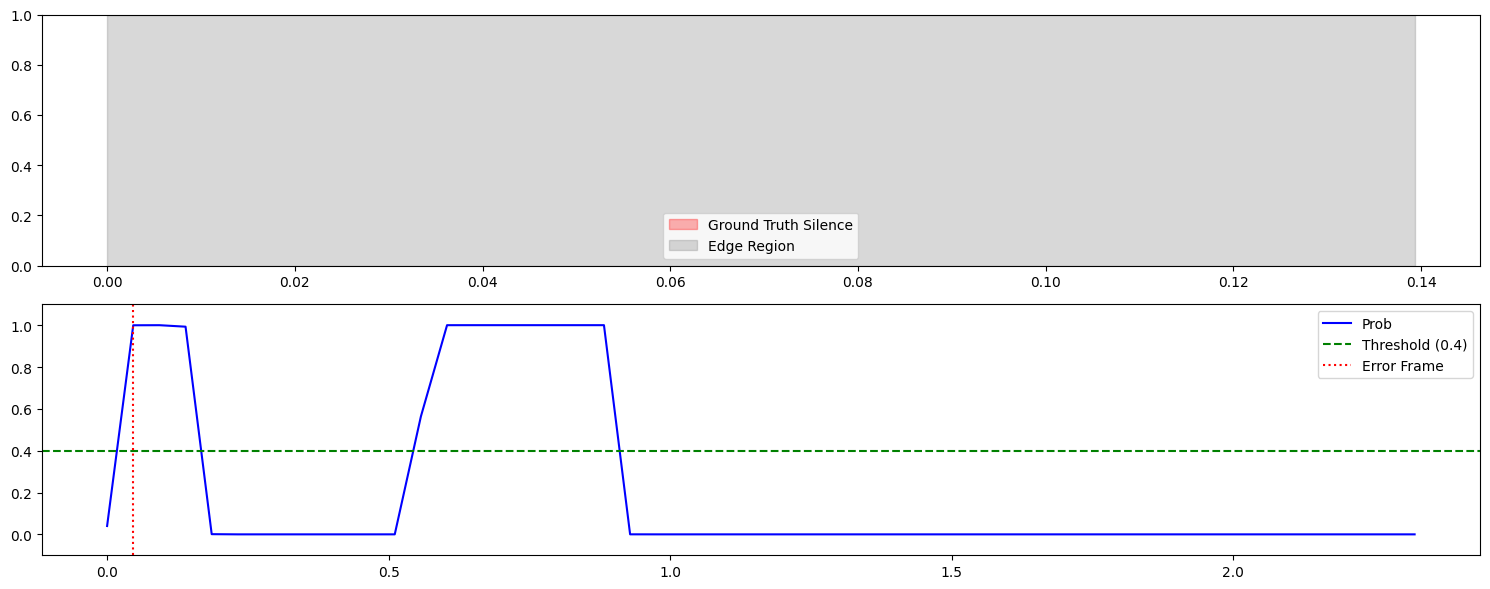

In [23]:
def plot_error_window(model, val_data, frame_idx, threshold=0.4, window=100):
    X_val, y_val, edge_val = val_data
    
    # Get window boundaries
    start = max(0, frame_idx - window//2)
    end = min(len(X_val), frame_idx + window//2)
    
    # Get predictions for window
    model.eval()
    with torch.no_grad():
        pred_probs = torch.sigmoid(model(X_val[start:end])).squeeze().cpu()
        
    # Create time axis (using your frame rate of 21.535)
    time = np.arange(start, end) / 21.535
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))
    
    # Ground truth
    ax1.fill_between(time, 0, 1, 
                    where=y_val[start:end].cpu().numpy()==1,
                    color='red', alpha=0.3, label='Ground Truth Silence')
    ax1.fill_between(time, 0, 1,
                    where=edge_val[start:end].cpu().numpy(),
                    color='gray', alpha=0.3, label='Edge Region')
    ax1.set_ylim(0, 1)
    ax1.legend()
    
    # Predictions
    ax2.plot(time, pred_probs, 'b-', label='Prob')
    ax2.axhline(y=threshold, color='g', linestyle='--', label=f'Threshold ({threshold})')
    ax2.axvline(x=frame_idx/21.535, color='r', linestyle=':', label='Error Frame')
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Look at first few examples of each type:
print("False Positive Example:")
plot_error_window(model, val_data, fp_frames[0])

print("\nFalse Negative Example:")
plot_error_window(model, val_data, fn_frames[0])

print("\nEdge Trigger Example:")
plot_error_window(model, val_data, edge_frames[0])

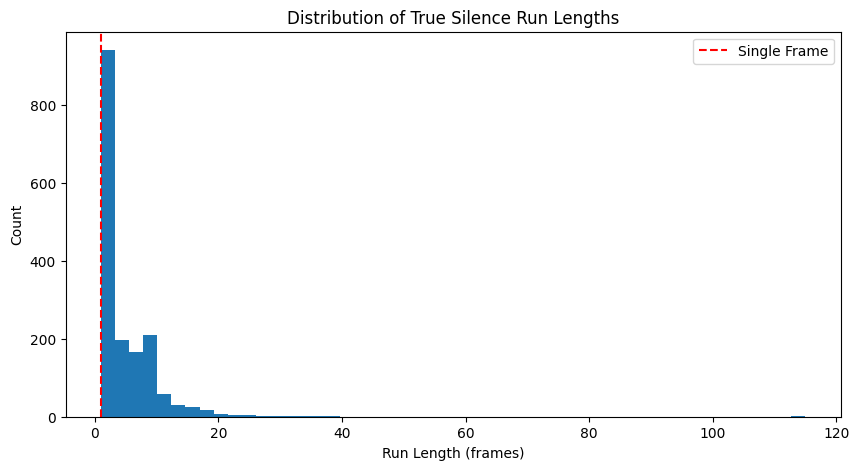


Total silence runs: 1670
Single frame runs: 593
Multi-frame runs: 1077
Average run length: 4.6 frames (214.9ms)


In [26]:
# Analyze true silence runs
def analyze_silence_runs(y_val, edge_val):
    # Get middle silences (not edges)
    middle_silence = (y_val == 1).cpu().numpy() & ~edge_val.cpu().numpy()
    
    # Find runs
    runs = []
    in_run = False
    run_start = 0
    
    for i in range(len(middle_silence)):
        if middle_silence[i] and not in_run:
            in_run = True
            run_start = i
        elif not middle_silence[i] and in_run:
            runs.append((run_start, i))
            in_run = False
    
    if in_run:
        runs.append((run_start, len(middle_silence)))
    
    # Get run lengths in frames
    run_lengths = [end - start for start, end in runs]
    
    plt.figure(figsize=(10, 5))
    plt.hist(run_lengths, bins=50)
    plt.axvline(x=1, color='r', linestyle='--', label='Single Frame')
    plt.xlabel('Run Length (frames)')
    plt.ylabel('Count')
    plt.title('Distribution of True Silence Run Lengths')
    plt.legend()
    plt.show()
    
    print(f"\nTotal silence runs: {len(runs)}")
    print(f"Single frame runs: {sum(l == 1 for l in run_lengths)}")
    print(f"Multi-frame runs: {sum(l > 1 for l in run_lengths)}")
    print(f"Average run length: {np.mean(run_lengths):.1f} frames ({np.mean(run_lengths)/21.535*1000:.1f}ms)")
    
    return runs, run_lengths

X_train, y_train, edge_train = train_data
runs, lengths = analyze_silence_runs(y_train, edge_train)

In [31]:
def analyze_chunk_lengths(y_val, edge_val):
    middle_silence = (y_val == 1).cpu().numpy() & ~edge_val.cpu().numpy()
    chunks = []
    chunk_start = 0
    silence_count = 0
    
    for i in range(len(middle_silence)):
        if middle_silence[i]:
            silence_count += 1
            # When we hit 2 frames of silence, the chunk before it ends
            if silence_count == 2:
                chunk_length = i - 1 - chunk_start  # -1 because we don't include the first silence frame
                if chunk_length > 0:  # Only count actual chunks
                    chunks.append(chunk_length)
        else:
            if silence_count >= 2:  # After a valid silence run ends
                chunk_start = i  # Start new chunk
            silence_count = 0
            
    # Add final chunk if it exists
    if chunk_start < len(middle_silence) and silence_count < 2:
        chunks.append(len(middle_silence) - chunk_start)
    
    chunks = np.array(chunks)
    print(f"Number of chunks: {len(chunks)}")
    print(f"Chunk lengths in frames (seconds):")
    print(f"Median: {np.median(chunks):.1f} ({np.median(chunks)/21.535:.2f}s)")
    print(f"Mean: {np.mean(chunks):.1f} ({np.mean(chunks)/21.535:.2f}s)")
    print(f"5th percentile: {np.percentile(chunks, 5):.1f} ({np.percentile(chunks, 5)/21.535:.2f}s)")
    print(f"25th percentile: {np.percentile(chunks, 25):.1f} ({np.percentile(chunks, 25)/21.535:.2f}s)")
    print(f"75th percentile: {np.percentile(chunks, 75):.1f} ({np.percentile(chunks, 75)/21.535:.2f}s)")
    print(f"95th percentile: {np.percentile(chunks, 95):.1f} ({np.percentile(chunks, 95)/21.535:.2f}s)")

analyze_chunk_lengths(y_train, edge_train)

Number of chunks: 1078
Chunk lengths in frames (seconds):
Median: 30.0 (1.39s)
Mean: 46.3 (2.15s)
5th percentile: 5.0 (0.23s)
25th percentile: 14.0 (0.65s)
75th percentile: 58.8 (2.73s)
95th percentile: 144.3 (6.70s)


In [46]:
def analyze_realistic_performance(model, val_data, threshold=0.4, min_run_length=2):
    """Analyze with configurable minimum run length for both true spans and predictions."""
    X_val, y_val, edge_val = val_data
    
    model.eval()
    with torch.no_grad():
        val_pred = torch.sigmoid(model(X_val)).squeeze().cpu().numpy()
    
    y_true = y_val.cpu().numpy()
    edge_mask = edge_val.cpu().numpy()
    
    # Find true silence runs (n+ frames)
    true_runs = []
    in_run = False
    run_start = 0
    run_length = 0
    
    for i in range(len(y_true)):
        if y_true[i] and not edge_mask[i]:
            if not in_run:
                in_run = True
                run_start = i
                run_length = 1
            else:
                run_length += 1
        elif in_run:
            if run_length >= min_run_length:  # Only keep runs of n+ frames
                true_runs.append((run_start, i))
            in_run = False
            run_length = 0
    
    if in_run and run_length >= min_run_length:
        true_runs.append((run_start, len(y_true)))
    
    # For each true run, check if we predicted at least n frames
    tp = 0
    fn = 0
    fp = 0
    
    for start, end in true_runs:
        span_preds = val_pred[start:end] > threshold
        if sum(span_preds) >= min_run_length:
            tp += 1
        else:
            fn += 1
    
    # Find false positive runs (where we predicted n+ frames outside true spans)
    pred_bool = val_pred > threshold
    in_fp_run = False
    fp_length = 0
    
    i = 0
    while i < len(pred_bool):
        in_true_span = any(start <= i < end for start, end in true_runs)
        if in_true_span:
            i = next(end for start, end in true_runs if start <= i < end)
            in_fp_run = False
            fp_length = 0
            continue
            
        if pred_bool[i] and not edge_mask[i]:
            if not in_fp_run:
                in_fp_run = True
                fp_length = 1
            else:
                fp_length += 1
                if fp_length == min_run_length:  # Count when we hit n frames
                    fp += 1
        else:
            in_fp_run = False
            fp_length = 0
        i += 1
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    print(f"\nAdjusted Metrics (minimum {min_run_length} frames, excluding edges):")
    print(f"True Positive Spans: {tp}")
    print(f"False Negative Spans: {fn}")
    print(f"False Positive Spans: {fp}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

# Let's try different run lengths:
for n in [2, 3, 4, 5]:
    analyze_realistic_performance(model, train_data, threshold=0.9, min_run_length=n)


Adjusted Metrics (minimum 2 frames, excluding edges):
True Positive Spans: 981
False Negative Spans: 96
False Positive Spans: 204
Precision: 0.8278
Recall: 0.9109
F1: 0.8674

Adjusted Metrics (minimum 3 frames, excluding edges):
True Positive Spans: 792
False Negative Spans: 68
False Positive Spans: 128
Precision: 0.8609
Recall: 0.9209
F1: 0.8899

Adjusted Metrics (minimum 4 frames, excluding edges):
True Positive Spans: 668
False Negative Spans: 62
False Positive Spans: 96
Precision: 0.8743
Recall: 0.9151
F1: 0.8942

Adjusted Metrics (minimum 5 frames, excluding edges):
True Positive Spans: 583
False Negative Spans: 37
False Positive Spans: 84
Precision: 0.8741
Recall: 0.9403
F1: 0.9060
